# Text to Image Generation with Diffusion Models
 This notebook demonstrates how to generate images from text prompts using a diffusion model. The script is divided into several sections, including the necessary imports, function definitions, model loading, and image generation.
## 1. Imports and Setup
First, we need to import the necessary libraries and set up the environment.


In [1]:

import argparse

In [2]:

import os
import cv2
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange
from torchvision.utils import make_grid
from pytorch_lightning import seed_everything
from torch import autocast
from contextlib import nullcontext
from imwatermark import WatermarkEncoder

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
from ldm.models.diffusion.dpm_solver import DPMSolverSampler

/home/mri1404/miniconda3/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.set_grad_enabled(False)

## 2. Helper Functions
 
We define some helper functions for chunking, loading the model, and parsing arguments.

In [4]:
def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())


def load_model_from_config(config, ckpt, device=torch.device("cuda"), verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    if device == torch.device("cuda"):
        model.cuda()
    elif device == torch.device("cpu"):
        model.cpu()
        model.cond_stage_model.device = "cpu"
    else:
        raise ValueError(f"Incorrect device name. Received: {device}")
    model.eval()
    return model


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--prompt",
        type=str,
        nargs="?",
        default="a professional photograph of an astronaut riding a triceratops",
        help="the prompt to render"
    )
    parser.add_argument(
        "--outdir",
        type=str,
        nargs="?",
        help="dir to write results to",
        default="outputs/txt2img-samples"
    )
    parser.add_argument(
        "--steps",
        type=int,
        default=50,
        help="number of ddim sampling steps",
    )
    parser.add_argument(
        "--plms",
        action='store_true',
        help="use plms sampling",
    )
    parser.add_argument(
        "--dpm",
        action='store_true',
        help="use DPM (2) sampler",
    )
    parser.add_argument(
        "--fixed_code",
        action='store_true',
        help="if enabled, uses the same starting code across all samples ",
    )
    parser.add_argument(
        "--ddim_eta",
        type=float,
        default=0.0,
        help="ddim eta (eta=0.0 corresponds to deterministic sampling",
    )
    parser.add_argument(
        "--n_iter",
        type=int,
        default=3,
        help="sample this often",
    )
    parser.add_argument(
        "--H",
        type=int,
        default=512,
        help="image height, in pixel space",
    )
    parser.add_argument(
        "--W",
        type=int,
        default=512,
        help="image width, in pixel space",
    )
    parser.add_argument(
        "--C",
        type=int,
        default=4,
        help="latent channels",
    )
    parser.add_argument(
        "--f",
        type=int,
        default=8,
        help="downsampling factor, most often 8 or 16",
    )
    parser.add_argument(
        "--n_samples",
        type=int,
        default=3,
        help="how many samples to produce for each given prompt. A.k.a batch size",
    )
    parser.add_argument(
        "--n_rows",
        type=int,
        default=0,
        help="rows in the grid (default: n_samples)",
    )
    parser.add_argument(
        "--scale",
        type=float,
        default=9.0,
        help="unconditional guidance scale: eps = eps(x, empty) + scale * (eps(x, cond) - eps(x, empty))",
    )
    parser.add_argument(
        "--from-file",
        type=str,
        help="if specified, load prompts from this file, separated by newlines",
    )
    parser.add_argument(
        "--config",
        type=str,
        default="configs/stable-diffusion/v2-inference.yaml",
        help="path to config which constructs model",
    )
    parser.add_argument(
        "--ckpt",
        type=str,
        help="path to checkpoint of model",
    )
    parser.add_argument(
        "--seed",
        type=int,
        default=42,
        help="the seed (for reproducible sampling)",
    )
    parser.add_argument(
        "--precision",
        type=str,
        help="evaluate at this precision",
        choices=["full", "autocast"],
        default="autocast"
    )
    parser.add_argument(
        "--repeat",
        type=int,
        default=1,
        help="repeat each prompt in file this often",
    )
    parser.add_argument(
        "--device",
        type=str,
        help="Device on which Stable Diffusion will be run",
        choices=["cpu", "cuda"],
        default="cpu"
    )
    parser.add_argument(
        "--torchscript",
        action='store_true',
        help="Use TorchScript",
    )
    parser.add_argument(
        "--ipex",
        action='store_true',
        help="Use Intel® Extension for PyTorch*",
    )
    parser.add_argument(
        "--bf16",
        action='store_true',
        help="Use bfloat16",
    )
    opt = parser.parse_args()
    return opt


def put_watermark(img, wm_encoder=None):
    if wm_encoder is not None:
        img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        img = wm_encoder.encode(img, 'dwtDct')
        img = Image.fromarray(img[:, :, ::-1])
    return img

## 3. Main Function 
The main function handles the logic of loading the model, setting up the sampling method, and generating images from text prompts.

In [5]:
# if opt.torchscript or opt.ipex:
#     transformer = model.cond_stage_model.model
#     unet = model.model.diffusion_model
#     decoder = model.first_stage_model.decoder
#     additional_context = torch.cpu.amp.autocast() if opt.bf16 else nullcontext()
#     shape = [opt.C, opt.H // opt.f, opt.W // opt.f]

#     if opt.bf16 and not opt.torchscript and not opt.ipex:
#         raise ValueError('Bfloat16 is supported only for torchscript+ipex')
#     if opt.bf16 and unet.dtype != torch.bfloat16:
#         raise ValueError("Use configs/stable-diffusion/intel/ configs with bf16 enabled if " +
#                          "you'd like to use bfloat16 with CPU.")
#     if unet.dtype == torch.float16 and device == torch.device("cpu"):
#         raise ValueError("Use configs/stable-diffusion/intel/ configs for your model if you'd like to run it on CPU.")

#     if opt.ipex:
#         import intel_extension_for_pytorch as ipex
#         bf16_dtype = torch.bfloat16 if opt.bf16 else None
#         transformer = transformer.to(memory_format=torch.channels_last)
#         transformer = ipex.optimize(transformer, level="O1", inplace=True)

#         unet = unet.to(memory_format=torch.channels_last)
#         unet = ipex.optimize(unet, level="O1", auto_kernel_selection=True, inplace=True, dtype=bf16_dtype)

#         decoder = decoder.to(memory_format=torch.channels_last)
#         decoder = ipex.optimize(decoder, level="O1", auto_kernel_selection=True, inplace=True, dtype=bf16_dtype)

#     if opt.torchscript:
#         with torch.no_grad(), additional_context:
#             # get UNET scripted
#             if unet.use_checkpoint:
#                 raise ValueError("Gradient checkpoint won't work with tracing. " +
#                 "Use configs/stable-diffusion/intel/ configs for your model or disable checkpoint in your config.")

#             img_in = torch.ones(2, 4, 96, 96, dtype=torch.float32)
#             t_in = torch.ones(2, dtype=torch.int64)
#             context = torch.ones(2, 77, 1024, dtype=torch.float32)
#             scripted_unet = torch.jit.trace(unet, (img_in, t_in, context))
#             scripted_unet = torch.jit.optimize_for_inference(scripted_unet)
#             print(type(scripted_unet))
#             model.model.scripted_diffusion_model = scripted_unet

#             # get Decoder for first stage model scripted
#             samples_ddim = torch.ones(1, 4, 96, 96, dtype=torch.float32)
#             scripted_decoder = torch.jit.trace(decoder, (samples_ddim))
#             scripted_decoder = torch.jit.optimize_for_inference(scripted_decoder)
#             print(type(scripted_decoder))
#             model.first_stage_model.decoder = scripted_decoder

#     prompts = data[0]
#     print("Running a forward pass to initialize optimizations")
#     uc = None
#     if opt.scale != 1.0:
#         uc = model.get_learned_conditioning(batch_size * [""])
#     if isinstance(prompts, tuple):
#         prompts = list(prompts)

#     with torch.no_grad(), additional_context:
#         for _ in range(3):
#             c = model.get_learned_conditioning(prompts)
#         samples_ddim, _ = sampler.sample(S=5,
#                                          conditioning=c,
#                                          batch_size=batch_size,
#                                          shape=shape,
#                                          verbose=False,
#                                          unconditional_guidance_scale=opt.scale,
#                                          unconditional_conditioning=uc,
#                                          eta=opt.ddim_eta,
#                                          x_T=start_code)
#         print("Running a forward pass for decoder")
#         for _ in range(3):
#             x_samples_ddim = model.decode_first_stage(samples_ddim)

## 4. Run the Script 
Finally, we parse the arguments and run the main function.

In [6]:
!python getopt.py --prompt "a dog running." --ckpt ../checkpoints/v2-1_768-nonema-pruned.ckpt --config ../configs/stable-diffusion/v2-inference-v.yaml --H 768 --W 768 --device cuda  

Namespace(prompt='a dog running.', outdir='outputs/txt2img-samples', steps=50, plms=False, dpm=False, fixed_code=False, ddim_eta=0.0, n_iter=3, H=768, W=768, C=4, f=8, n_samples=3, n_rows=0, scale=9.0, from_file=None, config='../configs/stable-diffusion/v2-inference-v.yaml', ckpt='../checkpoints/v2-1_768-nonema-pruned.ckpt', seed=42, precision='autocast', repeat=1, device='cuda', torchscript=False, ipex=False, bf16=False)


In [8]:
opt = argparse.Namespace(prompt='A picture of either a cat or a dog.', outdir='outputs/txt2img-samples', steps=100, plms=False, dpm=False, fixed_code=False, ddim_eta=0.0, n_iter=3, H=768, W=768, C=4, f=8, n_samples=3, n_rows=0, scale=9.0, from_file=None, config='../configs/stable-diffusion/v2-inference-v.yaml', ckpt='../checkpoints/v2-1_768-nonema-pruned.ckpt', seed=42, precision='autocast', repeat=1, device='cuda', torchscript=False, ipex=False, bf16=False)

In [9]:
opt.f

8

In [10]:
opt.config

'../configs/stable-diffusion/v2-inference-v.yaml'

In [11]:
#seed_everything(opt.seed)
config = OmegaConf.load(f"{opt.config}")
device = torch.device("cuda") if opt.device == "cuda" else torch.device("cpu")
model = load_model_from_config(config, f"{opt.ckpt}", device)

Loading model from ../checkpoints/v2-1_768-nonema-pruned.ckpt
Global Step: 110000
No module 'xformers'. Proceeding without it.
LatentDiffusion: Running in v-prediction mode
DiffusionWrapper has 865.91 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [ ]:
model.model.sequential_cross_attn

In [ ]:
model.model.diffusion_model.input_blocks[1][1].use_linear

In [ ]:
from ldm.modules.attention import CrossAttention
intermediate_outputs = {}

def hook_fn(module, input, output):
    layer_name = module.__class__.__name__
    if layer_name not in intermediate_outputs:
        intermediate_outputs[layer_name] = []
    intermediate_outputs[layer_name].append(output)

In [12]:
for i, tuple in enumerate(model.named_modules()):
    name, layer = tuple
    if isinstance(layer, GroupNorm):
        print(i,":", name)

NameError: name 'GroupNorm' is not defined

In [30]:
x_ts = []

In [31]:
def out_hook(module, inp, out):
    x_ts.append(out)

In [32]:
model.model.diffusion_model.out.register_forward_hook(out_hook)

In [ ]:
# look at middle block attention
# attn = list(model.modules())[342]
# attn.register_forward_hook(hook_fn)
# attn.to_v.register_forward_hook(hook_fn)

In [ ]:
# # from transformers import CLIPTokenizer
# # import torch
# from open_clip import SimpleTokenizer, tokenize
# # Load the CLIP tokenizer

# # Your prompt
# prompt = "A grand medieval castle on a cliffside overlooking a stormy ocean at twilight. The castle's towers and battlements rise high, surrounded by mist and dark clouds. Lightning flashes in the distant sky, illuminating the stone walls and moss-covered statues. Below, waves crash against the rocks, sending sprays of foam into the air."

# # Tokenize the prompt
# _tokenizer = SimpleTokenizer()

# s_tokens = [_tokenizer.decode([token]) for token in _tokenizer.encode(prompt)]
# s_tokens

In [ ]:
# z = model.cond_stage_model("An ancient, overgrown temple deep in the heart of a dense, enchanted jungle. The temple is made of weathered stone, covered in moss and vines, with intricate carvings of mythical creatures. Rays of golden sunlight filter through the thick canopy above, casting a mystical glow on the scene. In the foreground, a shimmering, ethereal blue pool of water reflects the towering trees and the crumbling temple. Exotic birds with vibrant feathers fly overhead, and faint traces of glowing fireflies dance around the ruins. The atmosphere is serene yet filled with a sense of untold magic and mystery")
# z.shape

In [ ]:
# # Add hooks to CrossAttention layers and their submodules
# for name, layer in model.named_modules():
#     if isinstance(layer, CrossAttention):  # Check for CrossAttention modules
        
#         # Register hook for the entire CrossAttention module
#         layer.register_forward_hook(hook_fn)
        
#         # Manually register hooks for specific submodules inside CrossAttention
#         if hasattr(layer, 'to_v'):  # Check if the submodule 'to_v' exists
#             layer.to_v.register_forward_hook(hook_fn)  # Hook for self.to_v

#         # Repeat for other submodules inside CrossAttention if needed
#         # Example for 'to_q', 'to_k', etc.
#         if hasattr(layer, 'to_q'):
#             layer.to_q.register_forward_hook(hook_fn)
#         if hasattr(layer, 'to_k'):
#             layer.to_k.register_forward_hook(hook_fn)


In [ ]:
# with torch.no_grad():
#     c = torch.cat([model.get_learned_conditioning(["A cockatiel being groomed."])], 1)
#     x = torch.randn([4, 768 // 8, 768 // 8], device=device)
#     # preprocessing
#     model.model.diffusion_model.input_blocks[1][1].norm(x)
#     x = rearrange(x, 'b c h w -> b (h w) c').contiguous()
#     x = model.model.diffusion_model.input_blocks[1][1].proj_in(x)
#     map = model.model.diffusion_model.input_blocks[1][1].transformer_blocks[0].attn1(x, context=[c]) # ? 
#     values = model.model.diffusion_model.input_blocks[1][1].transformer_blocks[0].attn1.to_v(c)
#     # noise = default(noise, lambda: torch.randn_like(x_start))abs
#     #     x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)

In [ ]:
type(model.model.diffusion_model.input_blocks[1][1].transformer_blocks[0].attn1) # todo: look at difference between map (attn1(tkn)) and values (self.to_v * tkn)

In [24]:
if opt.plms:
    sampler = PLMSSampler(model, device=device)
    print("Using PLMS")
elif opt.dpm:
    sampler = DPMSolverSampler(model, device=device)
    print("Using DPM")
else:
    sampler = DDIMSampler(model, device=device)
    print("Using DDIM")

Using DDIM


In [25]:
os.makedirs(opt.outdir, exist_ok=True)
outpath = opt.outdir
outpath

'outputs/txt2img-samples'

In [ ]:
# print("Creating invisible watermark encoder (see https://github.com/ShieldMnt/invisible-watermark)...")
# wm = "SDV2"
# wm_encoder = WatermarkEncoder()
# wm_encoder.set_watermark('bytes', wm.encode('utf-8'))

In [26]:
batch_size = opt.n_samples
n_rows = opt.n_rows if opt.n_rows > 0 else batch_size
if not opt.from_file:
    prompt = "A picture of either a dog or a cat."
    assert prompt is not None
    data = [batch_size * [prompt]]

else:
    print(f"reading prompts from {opt.from_file}")
    with open(opt.from_file, "r") as f:
        data = f.read().splitlines()
        data = [p for p in data for i in range(opt.repeat)]
        data = list(chunk(data, batch_size))
data

[['A picture of either a dog or a cat.',
  'A picture of either a dog or a cat.',
  'A picture of either a dog or a cat.']]

In [27]:
sample_path = os.path.join(outpath, "samples")
os.makedirs(sample_path, exist_ok=True)
sample_count = 0
base_count = len(os.listdir(sample_path))
grid_count = len(os.listdir(outpath)) - 1

start_code = None
if opt.fixed_code:
    start_code = torch.randn([opt.n_samples, opt.C, opt.H // opt.f, opt.W // opt.f], device=device)
start_code

In [28]:
precision_scope = autocast if opt.precision=="autocast" or opt.bf16 else nullcontext
precision_scope

torch.amp.autocast_mode.autocast

In [33]:
with torch.no_grad():
        with torch.autocast("cuda"), model.ema_scope():
            uc = model.get_learned_conditioning([""])
            c = model.get_learned_conditioning([prompt])
            samples_ddim, _ = sampler.sample(S=100,
                                             conditioning=c,
                                             batch_size=1,
                                             shape=[4, 768 // 8, 768 // 8],
                                             verbose=True,
                                             unconditional_guidance_scale=9.0,
                                             unconditional_conditioning=uc,
                                             eta=0.0,
                                             x_T=None)
            xs = model.decode_first_stage(samples_ddim)
            xs = torch.clamp((xs + 1.0) / 2.0, min=0.0, max=1.0)
            img = 255. * rearrange(xs[0].cpu().numpy(), 'c h w -> h w c')

Selected timesteps for ddim sampler: [  1  11  21  31  41  51  61  71  81  91 101 111 121 131 141 151 161 171
 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351
 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531
 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711
 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891
 901 911 921 931 941 951 961 971 981 991]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9895, 0.9804, 0.9708, 0.9609, 0.9505, 0.9398, 0.9287, 0.9171,
        0.9052, 0.8930, 0.8804, 0.8674, 0.8540, 0.8404, 0.8264, 0.8121, 0.7975,
        0.7827, 0.7675, 0.7521, 0.7365, 0.7207, 0.7047, 0.6885, 0.6722, 0.6557,
        0.6391, 0.6224, 0.6056, 0.5888, 0.5720, 0.5551, 0.5383, 0.5215, 0.5048,
        0.4882, 0.4716, 0.4552, 0.4390, 0.4229, 0.4070, 0.3913, 0.3758, 0.3605,
        0.3456, 0.3308, 0.3164, 0.3023, 0.2885, 0.2750, 0.2618, 0.2490, 0.2366,
        0.2245, 0.2128, 0.2014, 0.190

DDIM Sampler:  46%|███████████████████████████████▎                                    | 46/100 [24:03<28:14, 31.38s/it]


KeyboardInterrupt: 

In [34]:
x_ts

[tensor([[[[ 0.4226,  0.2930,  0.2280,  ...,  0.0284,  0.1621, -0.0019],
           [ 0.4822,  0.0845,  0.0964,  ...,  0.0105,  0.0837, -0.0397],
           [ 0.3186,  0.1804,  0.2180,  ...,  0.0504,  0.0914, -0.1169],
           ...,
           [ 0.3799,  0.1265,  0.1709,  ...,  0.1176,  0.2007,  0.0652],
           [ 0.2837,  0.1726,  0.1858,  ...,  0.0304,  0.0876,  0.0847],
           [ 0.3206,  0.2036,  0.2368,  ...,  0.0698,  0.0520,  0.0620]],
 
          [[ 0.3188,  0.2720,  0.2313,  ...,  0.0612,  0.0963, -0.0085],
           [ 0.2644,  0.2373,  0.2651,  ..., -0.0075, -0.0115, -0.0568],
           [ 0.2546,  0.3079,  0.2944,  ...,  0.0514,  0.0027, -0.1052],
           ...,
           [ 0.3369,  0.2266,  0.3435,  ...,  0.2211,  0.2336,  0.1897],
           [ 0.3611,  0.3184,  0.3118,  ...,  0.1786,  0.2438,  0.0867],
           [ 0.1869,  0.1670,  0.1733,  ...,  0.0247,  0.1875,  0.0474]],
 
          [[-0.1001, -0.2925, -0.3359,  ..., -0.1469, -0.2206, -0.1704],
           [-

In [ ]:
model.model.sequential_cross_attn

In [ ]:
intermediate_outputs.keys()

In [ ]:
len(intermediate_outputs["Linear"])

In [ ]:
len(intermediate_outputs["CrossAttention"])

In [ ]:
len(sampler.ddim_timesteps)

In [ ]:
# from transformers import CLIPTokenizer
# import torch
from open_clip import SimpleTokenizer, tokenize
# Load the CLIP tokenizer

# Your prompt

# Tokenize the prompt
_tokenizer = SimpleTokenizer()

s_tokens = [_tokenizer.decode([token]) for token in _tokenizer.encode(prompt)]
s_tokens

In [ ]:
t = 99
rand_token = 1
intermediate_outputs["CrossAttention"][t][:, rand_token + 77, :].shape

In [ ]:
magnitudes = {}
for i, s_token in enumerate(s_tokens):
    magnitudes[s_token] = torch.norm(intermediate_outputs["CrossAttention"][t][:, i + 77, :] - intermediate_outputs["Linear"][t][:, i + 77, :], dim = 1)
    print("map norm:", torch.norm(intermediate_outputs["CrossAttention"][t][:, i + 77, :]))
    print("val norm:", torch.norm(intermediate_outputs["Linear"][t][:, i + 77, :]))
magnitudes

In [ ]:
t = 1
magnitudes = {}
for i, s_token in enumerate(s_tokens):
    magnitudes[s_token] = torch.norm(intermediate_outputs["CrossAttention"][t][:, i + 77, :] - intermediate_outputs["Linear"][t][:, i + 77, :], dim = 1)
    print("map norm:", torch.norm(intermediate_outputs["CrossAttention"][t][:, i + 77, :]))
    print("val norm:", torch.norm(intermediate_outputs["Linear"][t][:, i + 77, :]))
magnitudes

In [ ]:
diff = intermediate_outputs["CrossAttention"][t][:, rand_token + 77, :] - intermediate_outputs["Linear"][t][:, rand_token + 77, :] 
diff.shape

In [ ]:
rand_token = 2
diff2 = intermediate_outputs["CrossAttention"][t][:, rand_token + 77, :] - intermediate_outputs["Linear"][t][:, rand_token + 77, :] 
diff2.shape

In [ ]:
diff

In [ ]:
# Normalize all values based on the second value in each tensor
# First, gather all second values to compute a normalization factor
second_values = torch.stack([values[1] for values in magnitudes.values()])
norm_factor = float(torch.max(second_values))  # For max normalization

# Apply normalization
normalized_magnitudes = {key: [float(values[0]), float(values[1]) / norm_factor] for key, values in magnitudes.items()}
normalized_magnitudes

In [ ]:
diff2

In [ ]:
torch.norm(diff2 - diff, dim=1)

In [ ]:
rand_token = 5
diff2 = intermediate_outputs["CrossAttention"][t][:, rand_token + 77, :] - intermediate_outputs["Linear"][t][:, rand_token + 77, :] 
diff2.shape

In [ ]:
torch.norm(diff2 - diff, dim=1)

In [ ]:
t = torch.tensor([1, 2])
t

In [ ]:
t[1] = 3
t

In [ ]:
dict(sorted(normalized_magnitudes.items(), key=lambda item: item[1][1]))

In [ ]:
dict(sorted(normalized_magnitudes.items(), key=lambda item: item[1][1]))

In [ ]:
Image.fromarray(img.astype(np.uint8))

In [ ]:
values = intermediate_outputs["Linear"]
map = intermediate_outputs["CrossAttention"]

In [ ]:
len(values)

In [ ]:
len(map)

In [ ]:
map[0].shape

In [ ]:
values[0].shape

In [ ]:
c.shape # will this change based on the # of tokens?

In [ ]:
uc.shape 

In [ ]:

with torch.no_grad(), \
    precision_scope(opt.device), \
    model.ema_scope():
        all_samples = list()
        for n in trange(opt.n_iter, desc="Sampling"):
            for prompts in tqdm(data, desc="data"):
                uc = None
                if opt.scale != 1.0:
                    uc = model.get_learned_conditioning(batch_size * [""])
                if isinstance(prompts, tuple):
                    prompts = list(prompts)
                c = model.get_learned_conditioning(prompts)
                shape = [opt.C, opt.H // opt.f, opt.W // opt.f]
                samples, _ = sampler.sample(S=opt.steps,
                                                 conditioning=c,
                                                 batch_size=opt.n_samples,
                                                 shape=shape,
                                                 verbose=False,
                                                 unconditional_guidance_scale=opt.scale,
                                                 unconditional_conditioning=uc,
                                                 eta=opt.ddim_eta,
                                                 x_T=start_code)

                x_samples = model.decode_first_stage(samples)
                x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)


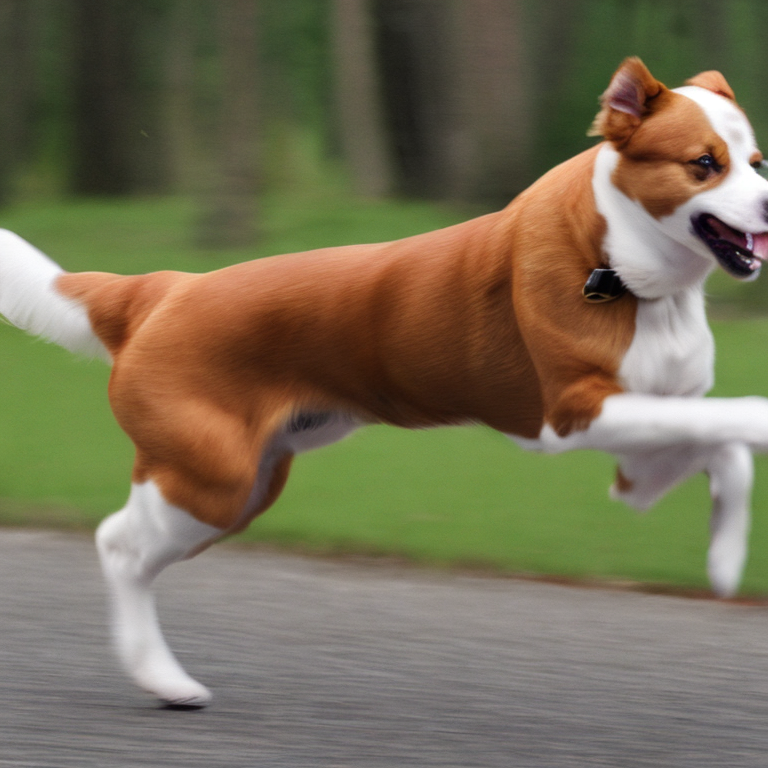

In [20]:
img = 255. * rearrange(x_samples[0].cpu().numpy(), 'c h w -> h w c')
Image.fromarray(img.astype(np.uint8))

In [ ]:
precision_scope = autocast if opt.precision=="autocast" or opt.bf16 else nullcontext
with torch.no_grad(), \
    precision_scope(opt.device), \
    model.ema_scope():
        all_samples = list()
        for n in trange(opt.n_iter, desc="Sampling"):
            for prompts in tqdm(data, desc="data"):
                uc = None
                if opt.scale != 1.0:
                    uc = model.get_learned_conditioning(batch_size * [""])
                if isinstance(prompts, tuple):
                    prompts = list(prompts)
                c = model.get_learned_conditioning(prompts)
                shape = [opt.C, opt.H // opt.f, opt.W // opt.f]
                print("S=", opt.steps,"conditioning=",c,
                                                 "batch_size=",opt.n_samples,
                                                 "shape=", shape,
                                                 "verbose=",False,
                                                 "unconditional_guidance_scale=",opt.scale,
                                                 "unconditional_conditioning=",uc,
                                                 "eta=",opt.ddim_eta,
                                                 "x_T=", start_code)
                samples, _ = sampler.sample(S=opt.steps,
                                                 conditioning=c,
                                                 batch_size=opt.n_samples,
                                                 shape=shape,
                                                 verbose=False,
                                                 unconditional_guidance_scale=opt.scale,
                                                 unconditional_conditioning=uc,
                                                 eta=opt.ddim_eta,
                                                 x_T=start_code)

                x_samples = model.decode_first_stage(samples)
                x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                for x_sample in x_samples:
                    x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                    img = Image.fromarray(x_sample.astype(np.uint8))
                    #img = put_watermark(img, wm_encoder)
                    img.save(os.path.join(sample_path, f"{base_count:05}.png"))
                    base_count += 1
                    sample_count += 1

                all_samples.append(x_samples)

        # additionally, save as grid
        grid = torch.stack(all_samples, 0)
        grid = rearrange(grid, 'n b c h w -> (n b) c h w')
        grid = make_grid(grid, nrow=n_rows)

        # to image
        grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
        grid = Image.fromarray(grid.astype(np.uint8))
        #grid = put_watermark(grid, wm_encoder)
        grid.save(os.path.join(outpath, f'grid-{grid_count:04}.png'))
        grid_count += 1

print(f"Your samples are ready and waiting for you here: \n{outpath} \n"
      f" \nEnjoy.")